# Conteúdo dos arquivos NWB

Este dataset contém gravações eletrofisiológicas no **córtex entorrinal (LEC, MEC)** e no **hipocampo (CA1)** de ratos Long Evans adultos, coletadas com sondas Neuropixels 2.0 em condições de livre comportamento.

---

## Estrutura dos Arquivos

Cada arquivo `.nwb` segue o padrão **NWB 2.0 (HDF5)** e inclui:

- **/epochs**  
  Blocos de tempo correspondentes a tarefas ou estados (ex.: *Foraging task*, *Natural sleep*, *Figure-eight*, *Odor sequence*, *Novel object*).  

- **/units**  
  Informações de cada unidade neuronal isolada após spike sorting (spike times, taxas médias, metadados de qualidade).  

- **/processing/behavior/position**  
  Trajetória do animal no plano 2D (x, y).  

- **/processing/behavior/direction**  
  Direção da cabeça do animal.  

- **/processing/behavior/speed**  
  Velocidade de deslocamento em cm/s.  

- **/time_intervals/**  
  Eventos específicos em tarefas de sequência:  
  - `mill_active` → quando a esteira estava ligada.  
  - `door_open` → quando a porta do labirinto foi aberta.  

- **/acquisition/**  
  Sinais eletrofisiológicos brutos (30 kHz), não utilizados diretamente nas tabelas derivadas.  

---

## Metadados Importantes

- **Subject ID**: identifica cada rato (9 sujeitos no total).  
- **session_description**: breve descrição do experimento.  
- **start_time / stop_time**: duração da sessão.  
- **task**: tipo de comportamento associado àquele bloco de gravação.  

---

## Tipos de Sessão

De acordo com o índice (`index.json`), os arquivos incluem registros de:

1. **Foraging task** – exploração em arena aberta em busca de comida.  
2. **Figure-eight task** – corrida em labirinto em forma de 8 com recompensa.  
3. **Odor sequence task** – tarefa de sequência de odores em esteira + recompensa.  
4. **Novel object task** – exploração de objetos novos em arena.  
5. **Natural sleep** – períodos de sono natural em caixa de descanso.  

---

## Uso dos Dados

A partir desses arquivos, é possível extrair:

- **Atividade neural (spike times, firing rates)** por unidade ou população.  
- **Comportamento** (posição, direção, velocidade, imobilidade).  
- **Estrutura temporal de eventos** durante cada tarefa.  

Os CSVs derivados organizam essa informação em **bins temporais** (ex.: 10 ms), unificando sinais neurais e variáveis comportamentais para análises de dinâmica populacional e replay.  

## Funções usadas para extrair o conteúdo

### Fluxo de Trabalho de Extração e Consolidação de Dados NWB (Neurodata Without Borders)

O processo foi dividido em duas fases principais, executadas por dois scripts Python:

- **`nwb_cru.py` (Extração):** Script responsável por acessar diretamente os dados crus armazenados no arquivo NWB e exportá-los para arquivos CSV individuais.  
- **`nwb_consolidate.py` (Consolidação):** Script que organiza, agrupa e combina os arquivos CSV individuais gerados pela fase de extração em arquivos maiores e padronizados.

---

## 1. Extração Crua (`nwb_cru.py`)

O script `nwb_cru.py` é a porta de entrada para os dados brutos. Ele segue o princípio da **Extração Crua**, ou seja, os dados são retirados do NWB no formato mais próximo do original, sem binning, médias ou transformações complexas.

### Conceitos Principais

| Conceito                         | O que é |
|----------------------------------|---------|
| **NWB (Neurodata Without Borders)** | Um **formato de arquivo padronizado** (baseado em HDF5) para armazenar dados de neurociência experimental, como eletrofisiologia, comportamento e imagem. |
| **pynwb**                        | Uma **biblioteca Python** que permite **ler e escrever arquivos NWB**, fornecendo acesso estruturado e padronizado aos dados. |
| **Leitura Preguiçosa (Lazy Loading)** | Um **método de carregamento sob demanda**. Em vez de trazer todos os dados (como milhões de spikes) para a memória de uma só vez, carrega apenas referências e lê dados em partes menores. Isso economiza memória RAM. |
| **units Table**                  | Uma **tabela interna do NWB** que armazena informações sobre cada unidade registrada (exemplo: ID, localização, eletrodo associado). |
| **Time Series / Spatial Series** | Estruturas no NWB para **armazenar dados contínuos no tempo**, com carimbo de tempo (timestamp). Exemplos: posição do animal ou velocidade de movimento. |

### Exportar para Planilhas

O script percorre cada arquivo NWB e gera os seguintes arquivos CSV ou JSON:

| Categoria de Dados  | Função de Extração             | Arquivo de Saída | O que é |
|---------------------|--------------------------------|------------------|---------|
| **Metadados**       | `get_session_meta`             | `[sessão]_metadata.json` | Informações gerais da sessão, como data, animal, equipamento, etc. |
| **Unidades / Células** | `get_units_table`           | `[sessão]_units.csv` | Lista de células/unidades registradas com seus atributos. |
| **Spike Times**     | `save_spike_times_to_csv`      | `[sessão]_spike_times.csv` | Registro dos instantes de disparo de cada célula. |
| **Épocas / Intervalos** | `get_epochs_df`, `get_time_intervals` | `[sessão]_epochs.csv`, `[sessão]_intervals_[nome].csv` | Períodos de interesse do experimento, como fases de estímulo ou repouso. |
| **Comportamento**   | `get_behavior_time_series`     | `[sessão]_[nome_serie].csv` | Dados contínuos relacionados ao comportamento, como posição ou velocidade. |

**Destaque:**  
A função `save_spike_times_to_csv` utiliza `get_spike_handles` e `iter_unit_spike_slices` para ler os *spike times* de forma eficiente, gerando um DataFrame final com colunas **unit_id** (identificador da célula) e **spike_time** (instante de disparo).

---

## 2. Consolidação de Dados (`nwb_consolidate.py`)

O script `nwb_consolidate.py` organiza e padroniza os arquivos CSV gerados na etapa anterior, criando conjuntos consolidados de dados para análise.

### Conceitos Principais

| Conceito | O que é |
|----------|---------|
| **Agrupamento por Mapeamento (CSV_MAPPING)** | Um **dicionário de configuração** que define como diferentes CSVs devem ser agrupados. Exemplo: arquivos de velocidade (`movement_speed.csv`, `head_yaw_speed.csv`) são combinados em um só (`consolidated_behavior_speed.csv`). |
| **Concatenação de DataFrames (pd.concat)** | Uma **operação da biblioteca Pandas** que empilha DataFrames linha a linha, unindo vários arquivos em um só. |
| **Colunas de Identificação (source_file)** | Uma **coluna adicional** que registra de qual sessão/arquivo NWB cada linha de dado veio. Isso garante rastreabilidade mesmo após a consolidação. |

### Fluxo de Funcionamento

1. **Configuração**  
   - Define as pastas de entrada (`INPUT_DIR`) e saída (`OUTPUT_DIR`).

2. **Iteração**  
   - Percorre todos os arquivos CSV presentes em `INPUT_DIR`.

3. **Identificação do Grupo**  
   - Para cada CSV, utiliza `CSV_MAPPING` e `find_csv_group` para determinar em qual arquivo consolidado ele será incluído.

4. **Injeção de Metadados**  
   - Lê o CSV em um DataFrame (`pd.read_csv`).  
   - Extrai o nome da sessão (exemplo: `27963_2022-Feb-09_08-02-57`).  
   - Adiciona a coluna `source_file` ao DataFrame para indicar a origem.  
   - Adiciona o DataFrame à lista do grupo correspondente.

5. **Agrupamento Final**  
   - Usa `pd.concat()` para unir todos os DataFrames de um grupo.  
   - Salva o resultado em um novo arquivo consolidado na `OUTPUT_DIR`.

---


# Buscando Dados

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
!pip install ydata-profiling


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from pathlib import Path
import pyarrow as pa
from math import floor, ceil
import pyarrow.parquet as pq
%matplotlib inline
from ydata_profiling import ProfileReport

In [ ]:
# # Puxa o csv
# df_behavior_position = pd.read_csv("/content/drive/MyDrive/replay_curve/nwb_consolidated_csv/consolidated_behavior_position.csv", low_memory=False)
# df_behavior_speed = pd.read_csv("/content/drive/MyDrive/replay_curve/nwb_consolidated_csv/consolidated_behavior_speed.csv", low_memory=False)
# df_epochs = pd.read_csv("/content/drive/MyDrive/replay_curve/nwb_consolidated_csv/consolidated_epochs.csv", low_memory=False)
# df_units = pd.read_csv("/content/drive/MyDrive/replay_curve/nwb_consolidated_csv/consolidated_units.csv", low_memory=False)
# df_spike_times = pd.read_csv("/content/drive/MyDrive/replay_curve/nwb_consolidated_csv/consolidated_spike_times.csv", low_memory=False)



In [3]:
CONS = Path("nwb_consolidated_csv_by_task")

# Definições de tipos mais econômicos
dtypes_position = {
    "source_file": "category",
    "timestamp": "float64",  # manter alta precisão para merges
    "animal_position_data_dim0": "float32",
    "animal_position_data_dim1": "float32",
    "animal_position_data_dim2": "float32",
    "head_direction_data_dim0": "float32",
}

dtypes_speed = {
    "source_file": "category",
    "timestamp": "float64",
    "head_yaw_speed_data": "float32",
    "movement_speed_data": "float32",
}

# Carregar CSVs com tipos
df_behavior_position = pd.read_csv(
    CONS / "consolidated__behavior_animal_position.csv",
    dtype=dtypes_position
)
df_behavior_speed = pd.read_csv(
    CONS / "consolidated__behavior_movement_speed.csv",
    dtype=dtypes_speed
)
df_epochs = pd.read_csv(CONS / "consolidated__epochs.csv")
df_units = pd.read_csv(CONS / "consolidated__units.csv")
df_spike_times = pd.read_csv(CONS / "consolidated__spike_times.csv")

print(df_behavior_position.shape)
print(df_behavior_speed.shape)
print(df_epochs.shape)
print(df_units.shape)
print(df_spike_times.shape)


(16403263, 6)
(16403263, 4)
(125, 15)
(136848, 8)
(136848, 5)


0            Figure-eight task
1            Figure-eight task
2            Figure-eight task
3            Figure-eight task
4            Figure-eight task
                   ...        
16403258    Odor sequence task
16403259    Odor sequence task
16403260    Odor sequence task
16403261    Odor sequence task
16403262    Odor sequence task
Name: task, Length: 16403263, dtype: object

In [4]:
print(df_behavior_position.shape)
print(df_behavior_speed.shape)
print(df_epochs.shape)
print(df_units.shape)
print(df_spike_times.shape)

(16403263, 6)
(16403263, 4)
(125, 15)
(136848, 8)
(136848, 5)


In [5]:
print(df_behavior_position.columns)
print(df_behavior_speed.columns)
print(df_epochs.columns)
print(df_units.columns)
print(df_spike_times.columns)

Index(['task', 'source_file', 'timestamp', 'animal_position_dim0',
       'animal_position_dim1', 'animal_position_dim2'],
      dtype='object')
Index(['task', 'source_file', 'timestamp', 'movement_speed'], dtype='object')
Index(['task', 'source_file', 'id', 'start_time', 'stop_time', 'arena',
       'arena_geometry', 'arena_dimensions', 'light_level', 'task_type_desc',
       'task_desc', 'arena_description', 'arena_objects', 'arena_cue_cards',
       'arena_curtains'],
      dtype='object')
Index(['task', 'source_file', 'sampling_rate', 'cluster_quality',
       'spike_times', 'electrodes', 'electrode_group', 'waveform_mean'],
      dtype='object')
Index(['task', 'source_file', 'file_id', 'unit_id', 'spike_time'], dtype='object')


In [6]:
df_behavior_position.head(2)

task                     source_file  timestamp   
0  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb  83.005243  \
1  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb  83.013588   

   animal_position_dim0  animal_position_dim1  animal_position_dim2  
0             14.858411             14.102147              91.44320  
1             14.834200             14.665543              91.32247

In [7]:
df_behavior_speed.head(2)


task                     source_file  timestamp   
0  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb  83.005243  \
1  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb  83.013588   

   movement_speed  
0       44.089717  
1       44.075707

In [8]:
df_epochs.head(2)

task                     source_file  id  start_time   
0  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb   0        83.0  \
1  Figure-eight task  26965_2020-Dec-08_10-46-12.nwb   0        47.0   

   stop_time                   arena arena_geometry  arena_dimensions   
0      978.0  figure8_treadmill_maze    rectangular  [130. 111.   5.]  \
1      955.0  figure8_treadmill_maze    rectangular  [130. 111.   5.]   

  light_level  task_type_desc task_desc  arena_description arena_objects   
0         dim             NaN       NaN                NaN           NaN  \
1         dim             NaN       NaN                NaN           NaN   

  arena_cue_cards arena_curtains  
0             NaN            NaN  
1             NaN            NaN

In [9]:
df_units.head(2)

task                     source_file  sampling_rate   
0  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb        30000.0  \
1  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb        30000.0   

  cluster_quality                                        spike_times   
0             mua  [ 83.00303333  83.0084      83.03283333 ... 97...  \
1             mua  [ 83.0043      83.0446      83.45046667 ... 92...   

                                          electrodes   
0     location                                   ...  \
1     location                                   ...   

                                     electrode_group   
0  probe_0 - 0-95; 1280-1375; 2560-2655; 3840-393...  \
1  probe_0 - 0-95; 1280-1375; 2560-2655; 3840-393...   

                                       waveform_mean  
0  [-38.502  -37.777  -37.562  -36.605  -36.489  ...  
1  [ -61.98300476  -62.07409925  -62.39089055  -6...

In [10]:
df_spike_times.head(2)

task                     source_file   
0  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb  \
1  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb   

                      file_id  unit_id  spike_time  
0  26965_2020-Dec-07_16-51-52        0       57971  
1  26965_2020-Dec-07_16-51-52        0       63890

### Documentação dos DataFrames

#### 1. `df_behavior_position`
Colunas:
- **source_file** → Nome do arquivo `.nwb` de onde os dados foram extraídos. Identifica a sessão/animal.
- **timestamp** → Tempo em segundos da gravação, alinhado entre posição e atividade neural.
- **animal_position_data_dim0** → Coordenada *x* (horizontal) da posição do animal na arena.
- **animal_position_data_dim1** → Coordenada *y* (vertical) da posição do animal.
- **animal_position_data_dim2** → Coordenada *z* (altura). No estudo normalmente projetada em 2D, mas ainda registrada.
- **head_direction_data_dim0** → Direção da cabeça do animal (em graus ou radianos), estimada a partir do tracking dos marcadores.

Este DataFrame descreve **trajetória e orientação da cabeça** do animal no espaço físico durante a sessão.

---

#### 2. `df_behavior_speed`
Colunas:
- **source_file** → Arquivo `.nwb` de origem.
- **timestamp** → Tempo em segundos.
- **head_yaw_speed_data** → Velocidade angular da cabeça (variação na direção da cabeça).
- **movement_speed_data** → Velocidade linear de deslocamento do animal (cm/s).

Este DataFrame mostra **como o animal se move**: tanto a translação (andar/correr) quanto a rotação da cabeça. (não será usado)

---

#### 3. `df_epochs`
Colunas:
- **source_file** → Arquivo `.nwb` de origem.
- **id** → Identificador único de cada epoch dentro do arquivo.
- **start_time** → Tempo inicial do epoch (s).
- **stop_time** → Tempo final do epoch (s).
- **task** → Tipo de tarefa ou condição comportamental (ex.: *Foraging task*, *Natural sleep*, *Odor sequence task*, *Novel object task*).
- **arena** → Identificação da arena experimental.
- **arena_geometry** → Forma geométrica da arena (ex.: quadrada, circular, figura-8).
- **arena_dimensions** → Dimensões da arena (ex.: 1m x 1m).
- **light_level** → Condição de iluminação (ex.: luz fraca, normal, escuro).

Este DataFrame descreve **as sessões experimentais** (períodos de sono, exploração, tarefas específicas).

---

#### 4. `df_units`
Colunas:
- **source_file** → Arquivo `.nwb` de origem.
- **id** → Identificador do cluster de spikes (neurônio isolado).
- **sampling_rate** → Taxa de amostragem usada na gravação desse cluster.
- **cluster_quality** → Qualidade da clusterização do spike (ex.: *good*, *mua* [multi-unit activity]).
- **spike_times** → Lista de tempos (s) em que os spikes desse neurônio ocorreram.
- **electrodes** → Número(s) de eletrodo(s) que captaram essa unidade.
- **electrode_group** → Grupo de eletrodos (ex.: qual região do probe Neuropixels).
- **waveform_mean** → Forma de onda média do spike, útil para classificação e validação da unidade.

Este DataFrame representa **metadados das unidades neuronais isoladas**.

---

#### 5. `df_spike_times`
Colunas:
- **source_file** → Arquivo `.nwb` de origem.
- **unit_id** → Identificador do neurônio (corresponde ao `id` de `df_units`).
- **spike_time** → Tempo (s) em que ocorreu um spike dessa unidade.

Este DataFrame é a versão **longa** dos spikes: cada linha corresponde a um **único disparo neural**.

---

Em resumo:  
- `df_behavior_position` e `df_behavior_speed` → comportamento (trajetória, velocidade, orientação).  
- `df_epochs` → contexto experimental (sono, tarefas).  
- `df_units` e `df_spike_times` → atividade neuronal (quais neurônios, quando dispararam, em quais condições).  


# Preparando Dados

#




# Behavior Position

In [35]:
use_cols = [
    "source_file", "timestamp",
    "animal_position_dim0", "animal_position_dim1", "task"
]
df_pos = df_behavior_position[use_cols]
df_pos = df_pos.rename(columns={
    "animal_position_dim0": "x",
    "animal_position_dim1": "y"
})

df_pos.head(2)

source_file  timestamp          x          y   
0  26965_2020-Dec-07_16-51-52.nwb  83.005243  14.858411  14.102147  \
1  26965_2020-Dec-07_16-51-52.nwb  83.013588  14.834200  14.665543   

                task  
0  Figure-eight task  
1  Figure-eight task

In [36]:
# mostra correlação entre colunas numericas
df_pos.select_dtypes(include=np.number).corr()

timestamp         x         y
timestamp   1.000000 -0.310032 -0.221553
x          -0.310032  1.000000  0.292827
y          -0.221553  0.292827  1.000000

carregamos o CSV bruto e ficamos só com tempo (timestamp) e posição XY (x, y). também guardamos source_file para sabermos de qual sessão veio cada linha.

In [37]:
# garante tipos corretos
df_pos["timestamp"] = pd.to_numeric(df_pos["timestamp"], errors="coerce")
df_pos["x"] = pd.to_numeric(df_pos["x"], errors="coerce")
df_pos["y"] = pd.to_numeric(df_pos["y"], errors="coerce")

# remove linhas sem x/y/timestamp
df_pos = df_pos.dropna(subset=["timestamp", "x", "y"]).copy()

# ordena por sessão e tempo
df_pos = df_pos.sort_values(["source_file", "task", "timestamp"]).reset_index(drop=True)

# remove duplicatas exatas (se houver)
df_pos = df_pos.drop_duplicates(subset=["source_file", "task", "timestamp", "x", "y"]).reset_index(drop=True)

df_pos.head(3)


source_file  timestamp          x          y   
0  26965_2020-Dec-07_16-51-52.nwb  83.005243  14.858411  14.102147  \
1  26965_2020-Dec-07_16-51-52.nwb  83.013588  14.834200  14.665543   
2  26965_2020-Dec-07_16-51-52.nwb  83.021923  14.893724  15.139888   

                task  
0  Figure-eight task  
1  Figure-eight task  
2  Figure-eight task

consertamos tipos numéricos, tiramos linhas vazias, ordenamos por tempo e removemos duplicatas. isso evita erros na hora de derivar velocidade.

In [39]:
df_pos["dx"] = df_pos.groupby(["source_file", "task"])["x"].diff().fillna(0)
df_pos["dy"] = df_pos.groupby(["source_file", "task"])["y"].diff().fillna(0)
df_pos["dt"] = df_pos.groupby(["source_file", "task"])["timestamp"].diff().fillna(0)
df_pos["speed_units_per_s"] = np.sqrt((df_pos["dx"]**2 + df_pos["dy"]**2) / df_pos["dt"]).fillna(0)

df_pos.head(3)

source_file  timestamp          x          y   
0  26965_2020-Dec-07_16-51-52.nwb  83.005243  14.858411  14.102147  \
1  26965_2020-Dec-07_16-51-52.nwb  83.013588  14.834200  14.665543   
2  26965_2020-Dec-07_16-51-52.nwb  83.021923  14.893724  15.139888   

                task        dx        dy        dt  speed_units_per_s  
0  Figure-eight task  0.000000  0.000000  0.000000           0.000000  
1  Figure-eight task -0.024211  0.563396  0.008345           6.172975  
2  Figure-eight task  0.059524  0.474345  0.008335           5.236558

Para cada sessão (source_file):
- dx = x[t] - x[t-1]
- dy = y[t] - y[t-1]

- Distância = sqrt(dx²+dy²).
- Velocidade ≈ distância / diferença de tempo (dt).

Vale entre os dois picos está em torno de **-1.3 a -1.0 em log₁₀**, ou seja:

- \(10^{-1.3} \approx 0.05\)  
- \(10^{-1.0} = 0.1\)

Então um bom **limiar inicial** para dizer se esta ou não imovel seria algo como **0.05 ou 0.07 units/s**.


In [40]:
def bin_timeseries(
    df,
    bin_size_s: float = 0.010,
):
    need_cols = {"source_file", "timestamp", "task"}
    if not need_cols.issubset(df.columns):
        raise ValueError(f"df precisa conter colunas {need_cols}")

    has_speed = "speed_units_per_s" in df.columns
    out = []

    # garante ordenação
    df = df.sort_values(["source_file", "timestamp"]).copy()

    for (sid, task), g in df.groupby(["source_file", "task"], group_keys=False):
        tmin, tmax = g["timestamp"].min(), g["timestamp"].max()
        edges = np.arange(tmin, tmax + bin_size_s, bin_size_s)
        if len(edges) < 2:
            continue

        # index do bin de cada amostra
        idx = np.searchsorted(edges, g["timestamp"].to_numpy(), side="right") - 1
        valid = (idx >= 0) & (idx < len(edges) - 1)
        gv = g.loc[valid].copy()
        gv["bin_idx"] = idx[valid]

        # agrega por bin
        grp = gv.groupby("bin_idx")
        n_in_bin = grp.size().reindex(range(len(edges) - 1), fill_value=0)

        # velocidade média por bin (se existir)
        if has_speed:
            speed_bin = (
                grp["speed_units_per_s"]
                .mean()
                .reindex(range(len(edges) - 1), fill_value=np.nan)
            ).to_numpy()
        else:
            speed_bin = np.full(len(edges) - 1, np.nan)

        centers = 0.5 * (edges[:-1] + edges[1:])
        out.append(
            pd.DataFrame({
                "source_file": sid,
                "bin_start_s": edges[:-1],
                "bin_end_s": edges[1:],
                "bin_center_s": centers,
                "speed_units_per_s": speed_bin,
                "n_samples_in_bin": n_in_bin.to_numpy(),
                "task": task,
            })
        )

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()


In [41]:
df_bins_pos = bin_timeseries(df_pos, bin_size_s=0.010)
df_bins_pos.head()

source_file  bin_start_s  bin_end_s  bin_center_s   
0  26965_2020-Dec-07_16-51-52.nwb    83.005243  83.015243     83.010243  \
1  26965_2020-Dec-07_16-51-52.nwb    83.015243  83.025243     83.020243   
2  26965_2020-Dec-07_16-51-52.nwb    83.025243  83.035243     83.030243   
3  26965_2020-Dec-07_16-51-52.nwb    83.035243  83.045243     83.040243   
4  26965_2020-Dec-07_16-51-52.nwb    83.045243  83.055243     83.050243   

   speed_units_per_s  n_samples_in_bin               task  
0           3.086488                 2  Figure-eight task  
1           5.236558                 1  Figure-eight task  
2           5.103067                 1  Figure-eight task  
3           4.621947                 1  Figure-eight task  
4           4.607780                 1  Figure-eight task

Dividimos o tempo em janelas (bins) de tamanho fixo e, para cada arquivo (source_file), calcula dentro de cada janela: quantas amostras caíram ali, a velocidade média e se o animal foi considerado imóvel ou não (pela regra da maioria dos pontos nesse intervalo). No final, ela retorna um DataFrame organizado por bins, com início, fim, centro, média de velocidade, status de e número de amostras em cada bin.

 O tamanho do bin (~10 ms) é escolhido porque eventos como replay e ripples duram apenas algumas dezenas de milissegundos — assim, essa resolução é suficiente para capturar essas dinâmicas rápidas sem tornar os dados esparsos demais.

## Epochs + Units

In [42]:
df_units["cluster_quality"].value_counts()

cluster_quality
mua     91843
good    45005
Name: count, dtype: int64

In [43]:
# extrai o número logo após "id" (linha seguinte)
df_units["id"] = df_units["electrodes"].str.extract(r"id\s+(\d+)")
df_units.head(1)


task                     source_file  sampling_rate   
0  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb        30000.0  \

  cluster_quality                                        spike_times   
0             mua  [ 83.00303333  83.0084      83.03283333 ... 97...  \

                                          electrodes   
0     location                                   ...  \

                                     electrode_group   
0  probe_0 - 0-95; 1280-1375; 2560-2655; 3840-393...  \

                                       waveform_mean  id  
0  [-38.502  -37.777  -37.562  -36.605  -36.489  ...  12

- **MUA (Multi-Unit Activity)**  
  Sigla para *Atividade Multiunidade*.  
  Representa a atividade elétrica registrada por um eletrodo que capta disparos de **vários neurônios próximos ao mesmo tempo**, sem conseguir separá-los com precisão.  
  - Serve para analisar **atividade populacional** — quando queremos saber o nível geral de disparo em uma região ou detectar eventos coletivos, como *sharp-wave ripples*.

- **Good (Single-Unit, SU)**  
  Indica que o cluster corresponde a **um neurônio isolado** com alta confiança.  
  Os spikes são consistentes e bem separados de outros neurônios.  
  - Serve para estudar **a codificação individual** dos neurônios, como *place cells* que disparam em posições específicas do ambiente.

---

Resumindo:  
- **MUA** → mistura de vários neurônios → útil para dinâmica global.  
- **Good** → um neurônio confiável → útil para análises finas de codificação.

Vamos usar os dois pois queremos saber se a população disparou muito num curto intervalo.

- mua = ajuda a detectar “quando” pode haver replay (candidatos).

- good = ajuda a entender “o que” está sendo reativado (conteúdo da trajetória).

In [47]:
# ids por classe
good_ids = df_units.loc[df_units["cluster_quality"]=="good", ["source_file","id", "task"]].rename(columns={"id":"unit_id"})
mua_ids  = df_units.loc[df_units["cluster_quality"]=="mua",  ["source_file","id", "task"]].rename(columns={"id":"unit_id"})

# para MUA (população): good + mua
all_ids = pd.concat([good_ids, mua_ids], ignore_index=True).drop_duplicates()
all_ids.head(3)

source_file unit_id               task
0  26965_2020-Dec-07_16-51-52.nwb     NaN  Figure-eight task
1  26965_2020-Dec-07_16-51-52.nwb      51  Figure-eight task
3  26965_2020-Dec-07_16-51-52.nwb      60  Figure-eight task

In [48]:
df_spike_times.head()

task                     source_file   
0  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb  \
1  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb   
2  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb   
3  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb   
4  Figure-eight task  26965_2020-Dec-07_16-51-52.nwb   

                      file_id unit_id  spike_time  
0  26965_2020-Dec-07_16-51-52       0       57971  
1  26965_2020-Dec-07_16-51-52       0       63890  
2  26965_2020-Dec-07_16-51-52       0       74608  
3  26965_2020-Dec-07_16-51-52       0      105900  
4  26965_2020-Dec-07_16-51-52       0      106283

In [49]:
# filtra spikes por classes
df_spike_times["unit_id"] = df_spike_times["unit_id"].astype(str)
all_ids["unit_id"]        = all_ids["unit_id"].astype(str)
good_ids["unit_id"]       = good_ids["unit_id"].astype(str)

spk_all  = df_spike_times.merge(all_ids,  on=["source_file","unit_id", "task"], how="inner")     # para MUA
spk_good = df_spike_times.merge(good_ids, on=["source_file","unit_id", "task"], how="inner")     # para per-unidade

In [50]:
spk_all.head(3)

task                     source_file                     file_id   
0  Foraging task  26863_2020-Nov-05_10-26-23.nwb  26863_2020-Nov-05_10-26-23  \
1  Foraging task  26863_2020-Nov-05_10-26-23.nwb  26863_2020-Nov-05_10-26-23   
2  Foraging task  26863_2020-Nov-05_10-26-23.nwb  26863_2020-Nov-05_10-26-23   

  unit_id  spike_time  
0       0        1780  
1       0        2500  
2       0        4918

In [51]:
spk_good.head(3)

task                     source_file                     file_id   
0  Foraging task  27284_2021-Jun-16_14-33-11.nwb  27284_2021-Jun-16_14-33-11  \
1  Foraging task  27284_2021-Jun-16_14-33-11.nwb  27284_2021-Jun-16_14-33-11   
2  Foraging task  27284_2021-Jun-16_14-33-11.nwb  27284_2021-Jun-16_14-33-11   

  unit_id  spike_time  
0       0        1780  
1       0        6873  
2       0        8889

In [52]:
# converte para timestamp usando a amostragem
spk_good["spike_time"] = spk_good["spike_time"] / 30000.0
spk_good.head()

task                     source_file                     file_id   
0  Foraging task  27284_2021-Jun-16_14-33-11.nwb  27284_2021-Jun-16_14-33-11  \
1  Foraging task  27284_2021-Jun-16_14-33-11.nwb  27284_2021-Jun-16_14-33-11   
2  Foraging task  27284_2021-Jun-16_14-33-11.nwb  27284_2021-Jun-16_14-33-11   
3  Foraging task  27284_2021-Jun-16_14-33-11.nwb  27284_2021-Jun-16_14-33-11   
4  Foraging task  27284_2021-Jun-16_14-33-11.nwb  27284_2021-Jun-16_14-33-11   

  unit_id  spike_time  
0       0    0.059333  
1       0    0.229100  
2       0    0.296300  
3       0    0.662700  
4       0    0.697000

In [53]:
spk_all["spike_time"] = spk_all["spike_time"] / 30000.0
spk_all.head()

task                     source_file                     file_id   
0  Foraging task  26863_2020-Nov-05_10-26-23.nwb  26863_2020-Nov-05_10-26-23  \
1  Foraging task  26863_2020-Nov-05_10-26-23.nwb  26863_2020-Nov-05_10-26-23   
2  Foraging task  26863_2020-Nov-05_10-26-23.nwb  26863_2020-Nov-05_10-26-23   
3  Foraging task  26863_2020-Nov-05_10-26-23.nwb  26863_2020-Nov-05_10-26-23   
4  Foraging task  26863_2020-Nov-05_10-26-23.nwb  26863_2020-Nov-05_10-26-23   

  unit_id  spike_time  
0       0    0.059333  
1       0    0.083333  
2       0    0.163933  
3       0    0.217833  
4       0    0.315933

Separamos quais unidades são good e mua; criamos dois subconjuntos de spikes: todos (good+mua) para sinal populacional, e só good para análises por neurônio.

In [54]:
import numpy as np
import pandas as pd
from math import ceil

def _floor_to_bin(x, bin_size):
    return bin_size * np.floor(x / bin_size)

def _build_bins_from_index(bin_idx, t0, bin_size):
    start = t0 + bin_idx * bin_size
    end   = start + bin_size
    center = start + 0.5 * bin_size
    return start, end, center


def bin_spikes_population(spk_df, bin_size_s, t0_por_sessao, window_size_s=None):
    """
    Faz binning dos spikes em nível de população (MUA).
    Agrupa por (source_file, task).
    """
    rows = []
    for (sid, task), g in spk_df.groupby(["source_file", "task"], group_keys=False):
        if g.empty:
            continue

        # tempo inicial de referência
        t0 = float(t0_por_sessao.get(
            sid, 
            _floor_to_bin(float(g["spike_time"].min()), bin_size_s)
        ))
        tmin = float(g["spike_time"].min())
        tmax = float(g["spike_time"].max())
        n_units = g["unit_id"].nunique()

        if not window_size_s:
            bin_idx = np.floor((g["spike_time"].to_numpy() - t0) / bin_size_s).astype(np.int64)
            counts = pd.Series(1, index=bin_idx).groupby(level=0).sum()
            idx = counts.index.to_numpy()
            start, end, center = _build_bins_from_index(idx, t0, bin_size_s)

            out = pd.DataFrame({
                "source_file": sid,
                "task":        task,
                "bin_idx":     idx,
                "bin_start_s": start,
                "bin_end_s":   end,
                "bin_center_s": center,
                "bin_size_s":  bin_size_s,
                "mua_count":   counts.to_numpy(dtype=np.int32),
                "mua_rate_hz": counts.to_numpy(dtype=np.float32) / bin_size_s,
                "n_units":     n_units
            })
            rows.append(out)

        else:
            w = float(window_size_s)
            n_chunks = int(ceil((tmax - tmin) / w)) if (tmax > tmin) else 1

            for k in range(n_chunks):
                a = tmin + k * w
                b = min(a + w, tmax)
                sel = g[(g["spike_time"] >= a) & (g["spike_time"] < b)]
                if sel.empty:
                    continue

                bin_idx = np.floor((sel["spike_time"].to_numpy() - t0) / bin_size_s).astype(np.int64)
                counts = pd.Series(1, index=bin_idx).groupby(level=0).sum()
                idx = counts.index.to_numpy()
                start, end, center = _build_bins_from_index(idx, t0, bin_size_s)

                rows.append(pd.DataFrame({
                    "source_file": sid,
                    "task":        task,
                    "bin_idx":     idx,
                    "bin_start_s": start,
                    "bin_end_s":   end,
                    "bin_center_s": center,
                    "bin_size_s":  bin_size_s,
                    "mua_count":   counts.to_numpy(dtype=np.int32),
                    "mua_rate_hz": counts.to_numpy(dtype=np.float32) / bin_size_s,
                    "n_units":     n_units
                }))

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()


def bin_spikes_per_unit_good(spk_df, bin_size_s, t0_por_sessao, window_size_s=None):
    """
    Faz binning dos spikes em nível de unidade (single-units).
    Agrupa por (source_file, task).
    """
    rows = []
    for (sid, task), g in spk_df.groupby(["source_file", "task"], group_keys=False):
        if g.empty:
            continue

        # tempo inicial de referência
        t0 = float(t0_por_sessao.get(
            sid,
            _floor_to_bin(float(g["spike_time"].min()), bin_size_s)
        ))
        tmin = float(g["spike_time"].min())
        tmax = float(g["spike_time"].max())

        if not window_size_s:
            bin_idx = np.floor((g["spike_time"].to_numpy() - t0) / bin_size_s).astype(np.int64)
            df_idx = pd.DataFrame({"unit_id": g["unit_id"].to_numpy(), "bin_idx": bin_idx})
            counts = df_idx.value_counts(["unit_id", "bin_idx"]).reset_index(name="count")

            start, end, center = _build_bins_from_index(counts["bin_idx"].to_numpy(), t0, bin_size_s)

            rows.append(pd.DataFrame({
                "source_file":  sid,
                "task":         task,
                "unit_id":      counts["unit_id"].astype(int).to_numpy(),
                "bin_idx":      counts["bin_idx"].to_numpy(),
                "bin_start_s":  start,
                "bin_end_s":    end,
                "bin_center_s": center,
                "count":        counts["count"].astype(np.int32).to_numpy()
            }))

        else:
            w = float(window_size_s)
            n_chunks = int(ceil((tmax - tmin) / w)) if (tmax > tmin) else 1

            for k in range(n_chunks):
                a = tmin + k * w
                b = min(a + w, tmax)
                sel = g[(g["spike_time"] >= a) & (g["spike_time"] < b)]
                if sel.empty:
                    continue

                bin_idx = np.floor((sel["spike_time"].to_numpy() - t0) / bin_size_s).astype(np.int64)
                df_idx = pd.DataFrame({"unit_id": sel["unit_id"].to_numpy(), "bin_idx": bin_idx})
                counts = df_idx.value_counts(["unit_id", "bin_idx"]).reset_index(name="count")

                start, end, center = _build_bins_from_index(counts["bin_idx"].to_numpy(), t0, bin_size_s)

                rows.append(pd.DataFrame({
                    "source_file":  sid,
                    "task":         task,
                    "unit_id":      counts["unit_id"].astype(int).to_numpy(),
                    "bin_idx":      counts["bin_idx"].to_numpy(),
                    "bin_start_s":  start,
                    "bin_end_s":    end,
                    "bin_center_s": center,
                    "count":        counts["count"].astype(np.int32).to_numpy()
                }))

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()


In [56]:
t0_por_sessao = (
    df_bins_pos.groupby(["source_file", "task"])["bin_start_s"]
    .min()
    .apply(lambda t: _floor_to_bin(float(t), 0.010))
    .to_dict()
)


df_spk_pop = bin_spikes_population(spk_all, 0.010, t0_por_sessao)
df_spk_unit = bin_spikes_per_unit_good(spk_good, 0.010, t0_por_sessao)


In [57]:
# lê o tamanho do dataset
print(df_spk_pop.shape)
print(df_spk_unit.shape)

(56356, 10)
(41173, 8)


In [58]:
df_spk_pop.head()

source_file           task  bin_idx  bin_start_s   
0  26863_2020-Nov-05_10-26-23.nwb  Foraging task        0         0.05  \
1  26863_2020-Nov-05_10-26-23.nwb  Foraging task        3         0.08   
2  26863_2020-Nov-05_10-26-23.nwb  Foraging task       11         0.16   
3  26863_2020-Nov-05_10-26-23.nwb  Foraging task       16         0.21   
4  26863_2020-Nov-05_10-26-23.nwb  Foraging task       26         0.31   

   bin_end_s  bin_center_s  bin_size_s  mua_count  mua_rate_hz  n_units  
0       0.06         0.055        0.01          1        100.0        1  
1       0.09         0.085        0.01          1        100.0        1  
2       0.17         0.165        0.01          1        100.0        1  
3       0.22         0.215        0.01          1        100.0        1  
4       0.32         0.315        0.01          1        100.0        1

#### Binning de Spikes — Resumo

##### `_floor_to_bin(x, bin_size)`
Arredonda `x` para o início do bin:  
`bin_size * floor(x / bin_size)`

**Por quê:** fixa a borda esquerda do bin e evita erros de ponto flutuante que deslocariam índices.

---

##### `_build_bins_from_index(bin_idx, t0, bin_size)`
Converte índice inteiro → tempos `start`, `end`, `center`.

**Por quê:** separa “índice inteiro” de “tempo real”, facilita merges/plots e reduz erro numérico.

---

##### `bin_spikes_population(spk_df, bin_size_s, t0_por_sessao, window_size_s=None)`

Agrega **MUA** (todos os spikes) por sessão e bin.

- `groupby(source_file)` isola sessões.
- **t0:** usa mapa por sessão ou `floor(min_time)` para alinhar bins estavelmente.
- **bin_idx:** `floor((spike_time - t0) / bin_size)`
- **Contagem esparsa:**  
  `Series(1, index=bin_idx).groupby(level=0).sum()` → não cria bins vazios.
- Constrói `bin_start`, `bin_end`, `bin_center`.
- Calcula `mua_rate_hz = count / bin_size`.
- Inclui `n_units` como metadado.
- Com `window_size_s`: processa em chunks `[a, b)` para poupar memória mantendo o mesmo `t0` (índices consistentes).

---

##### `bin_spikes_per_unit_good(spk_df, bin_size_s, t0_por_sessao, window_size_s=None)`

Conta spikes **por unidade × bin** (formato longo e esparso).

- Mesmo `t0` e `bin_idx`.
- Usa `value_counts(["unit_id", "bin_idx"])` → obtém apenas pares com spikes.
- Constrói `bin_start`, `bin_end`, `bin_center`.
- Retorna `count` (`int32`).
- Com janelas, mesmo racional de memória.

---

##### Notas

- Bins vazios **não aparecem** (use `reindex` se precisar de zeros).
- Tipos `int32`/`float32` reduzem uso de memória.
- Intervalo **half-open `[a, b)`** evita dupla contagem nas bordas.


In [59]:
df_bins_pos.head()

source_file  bin_start_s  bin_end_s  bin_center_s   
0  26965_2020-Dec-07_16-51-52.nwb    83.005243  83.015243     83.010243  \
1  26965_2020-Dec-07_16-51-52.nwb    83.015243  83.025243     83.020243   
2  26965_2020-Dec-07_16-51-52.nwb    83.025243  83.035243     83.030243   
3  26965_2020-Dec-07_16-51-52.nwb    83.035243  83.045243     83.040243   
4  26965_2020-Dec-07_16-51-52.nwb    83.045243  83.055243     83.050243   

   speed_units_per_s  n_samples_in_bin               task  
0           3.086488                 2  Figure-eight task  
1           5.236558                 1  Figure-eight task  
2           5.103067                 1  Figure-eight task  
3           4.621947                 1  Figure-eight task  
4           4.607780                 1  Figure-eight task

In [60]:
df_spk_pop.head()

source_file           task  bin_idx  bin_start_s   
0  26863_2020-Nov-05_10-26-23.nwb  Foraging task        0         0.05  \
1  26863_2020-Nov-05_10-26-23.nwb  Foraging task        3         0.08   
2  26863_2020-Nov-05_10-26-23.nwb  Foraging task       11         0.16   
3  26863_2020-Nov-05_10-26-23.nwb  Foraging task       16         0.21   
4  26863_2020-Nov-05_10-26-23.nwb  Foraging task       26         0.31   

   bin_end_s  bin_center_s  bin_size_s  mua_count  mua_rate_hz  n_units  
0       0.06         0.055        0.01          1        100.0        1  
1       0.09         0.085        0.01          1        100.0        1  
2       0.17         0.165        0.01          1        100.0        1  
3       0.22         0.215        0.01          1        100.0        1  
4       0.32         0.315        0.01          1        100.0        1

In [62]:
# aplica grupo a grupo
def recompute_bin_idx(g):
    sid = g["source_file"].iloc[0]
    t0  = t0_por_sessao.get(sid, 0.0)   # se não existir no dicionário, usa 0.0
    return np.floor((g["bin_start_s"] - g["bin_start_s"].min() + t0) / 0.010).astype(np.int64)

df_bins_pos["bin_idx"] = df_bins_pos.groupby(["source_file","task"], group_keys=False).apply(recompute_bin_idx)


In [63]:
# merge robusto
cols_pos_keep = ["source_file","bin_idx", "speed_units_per_s", "task"]
df_bins_all = df_spk_pop.merge(df_bins_pos[cols_pos_keep], on=["source_file","bin_idx", "task"], how="inner")

cols_pos_keep = ["source_file","bin_idx", "speed_units_per_s", "task"]
df_bins_unit = df_spk_unit.merge(df_bins_pos[cols_pos_keep], on=["source_file","bin_idx", "task"], how="inner")

In [64]:
print(df_bins_all.shape)
df_bins_all.head()

(56372, 11)


source_file           task  bin_idx  bin_start_s   
0  26863_2020-Nov-05_10-26-23.nwb  Foraging task        0         0.05  \
1  26863_2020-Nov-05_10-26-23.nwb  Foraging task        0         0.05   
2  26863_2020-Nov-05_10-26-23.nwb  Foraging task        3         0.08   
3  26863_2020-Nov-05_10-26-23.nwb  Foraging task       11         0.16   
4  26863_2020-Nov-05_10-26-23.nwb  Foraging task       16         0.21   

   bin_end_s  bin_center_s  bin_size_s  mua_count  mua_rate_hz  n_units   
0       0.06         0.055        0.01          1        100.0        1  \
1       0.06         0.055        0.01          1        100.0        1   
2       0.09         0.085        0.01          1        100.0        1   
3       0.17         0.165        0.01          1        100.0        1   
4       0.22         0.215        0.01          1        100.0        1   

   speed_units_per_s  
0           1.780258  
1           2.599777  
2           2.592484  
3           1.796421  
4           2.425506

In [68]:
print(df_bins_unit.shape)
df_bins_unit.head()

(41184, 9)


source_file           task  unit_id  bin_idx   
0  27284_2021-Jun-16_14-33-11.nwb  Foraging task        0     3648  \
1  27284_2021-Jun-16_14-33-11.nwb  Foraging task        0     8805   
2  27284_2021-Jun-16_14-33-11.nwb  Foraging task        0     8648   
3  27284_2021-Jun-16_14-33-11.nwb  Foraging task        0    15635   
4  27284_2021-Jun-16_14-33-11.nwb  Foraging task        0     3416   

   bin_start_s  bin_end_s  bin_center_s  count  speed_units_per_s  
0        36.53      36.54        36.535      7           0.229663  
1        88.10      88.11        88.105      3           0.981615  
2        86.53      86.54        86.535      3           0.229752  
3       156.40     156.41       156.405      3           2.461816  
4        34.21      34.22        34.215      2           0.927551

In [69]:
print("Classes em df_bins_all['task']:")
print(df_bins_all["task"].value_counts(dropna=False))

Classes em df_bins_all['task']:
task
Odor sequence task    31156
Foraging task          9273
Novel object task      8258
Natural sleep          7685
Name: count, dtype: int64


## Separa em Sleep e Activity

In [70]:
all_sleep = df_bins_all.loc[df_bins_all["task"].str.lower() == "natural sleep"]
all_activity = df_bins_all.loc[df_bins_all["task"].str.lower() != "natural sleep"]

print(all_sleep.shape)


(7685, 11)


In [71]:
unit_sleep = df_bins_unit.loc[df_bins_unit["task"].str.lower() == "natural sleep"]
unit_activity = df_bins_unit.loc[df_bins_unit["task"].str.lower() != "natural sleep"]


# Explorando os Datasets

In [72]:
profile = ProfileReport(all_sleep, title="Dataset de eventos candidatos de replay", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 31.56it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [73]:
profile = ProfileReport(df_bins_unit, title="Dataset de spikes de reconstrução", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 18.32it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

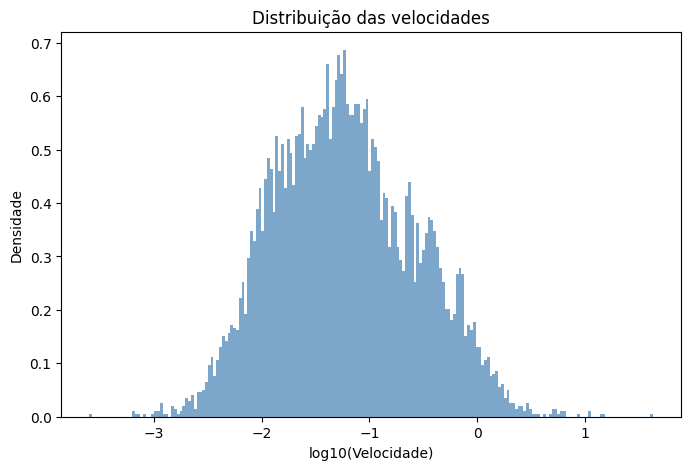

In [82]:
# Preparar os dados: tirar NaNs e infinitos
speed = all_sleep["speed_units_per_s"].dropna()
speed = speed[speed > 0]   # ignora zeros artificiais

# Usa log pois a distribuição é muito distorcida
use_log = True
data = np.log10(speed) if use_log else speed

# 3. Plotar histograma
plt.figure(figsize=(8,5))
plt.hist(data, bins=200, density=True, alpha=0.7, color="steelblue")
plt.xlabel("log10(Velocidade)" if use_log else "Velocidade (units/s)")
plt.ylabel("Densidade")
plt.title("Distribuição das velocidades")
plt.show()


In [ ]:
IMMOBILE_THRESHOLD = 0.5
all_sleep["is_immobile"] = (all_sleep["speed_units_per_s"] <= IMMOBILE_THRESHOLD).astype(int)
all_sleep.head(3)


source_file  timestamp         x          y       dx   
0  26863_2020-Nov-04_12-46-06  21.002567 -65.92006 -43.440395  0.00000  \
1  26863_2020-Nov-04_12-46-06  21.010900 -65.89455 -43.429806  0.02551   
2  26863_2020-Nov-04_12-46-06  21.019233 -65.87689 -43.428844  0.01766   

         dy        dt  speed_units_per_s  is_immobile  
0  0.000000  0.000000           0.000000            1  
1  0.010589  0.008333           0.302566            1  
2  0.000962  0.008333           0.193742            1

# Modelos

## Redes Bayesianas